## Import Data

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv('traindrug.csv',encoding = "ISO-8859-1")
data = df.values[:, 0]
labels = df.values[:, 1]

testDf = pd.read_csv('testdrug.csv')
testData = testDf.values[:, 0]
testLabels = testDf.values[:, 1]

## Word2Vec and GloVe

In [3]:
from gensim.models import KeyedVectors
import re

file = 'GoogleNews-vectors-negative300.bin'
word2vec = KeyedVectors.load_word2vec_format(file, binary=True, limit=50000)
word2vec_vectors = word2vec.wv

gloveFile = 'glove.6B.300d.txt.word2vec'
glove = KeyedVectors.load_word2vec_format(gloveFile, binary=False, limit=50000)
glove_vectors = glove.wv

<ipython-input-3-668db1155db1>:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  word2vec_vectors = word2vec.wv
<ipython-input-3-668db1155db1>:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  glove_vectors = glove.wv


In [4]:
def text2vec(list):
    vectors = []
    for row in list:
        tokens = [w.lower() for w in re.sub(r'[^\w\s]','',row).split(' ')]
        temp = []
        for token in tokens:
            if token in word2vec_vectors:
                temp.append(word2vec[token])
        vectors.append(np.mean(temp, axis=0))
    return np.asarray(vectors)

In [5]:
#Converting text data into vectors
def text2glove(list):
    vectors = []
    for row in list:
        tokens = [w.lower() for w in re.sub(r'[^\w\s]','',row).split(' ')]
        temp = []
        for token in tokens:
            if token in glove_vectors:
                temp.append(glove[token])
        vectors.append(np.mean(temp, axis=0))
    return np.asarray(vectors)

In [106]:
dataTrain = text2vec(data)
dataTest = text2vec(testData)

In [111]:
dataTrain = text2glove(data)
dataTest = text2glove(testData)

## Keras Imports

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, GlobalMaxPooling1D, Dropout, Embedding, LSTM
from keras import optimizers
from keras.layers.embeddings import Embedding
from keras import initializers
from keras.regularizers import l1
import tensorflow
import matplotlib.pyplot as plt

tensorflow.random.set_seed(0)
np.random.seed(0)

In [8]:
testLabels = np.asarray(testLabels).astype(np.float32)
labels = np.asarray(labels).astype(np.float32)

## MLP Vector

Epoch 1/50
32/32 [==============================] - 0s 6ms/step - loss: 1.9187 - mse: 1.6320 - mae: 1.0353 - val_loss: 0.9172 - val_mse: 0.6898 - val_mae: 0.7175
Epoch 2/50
32/32 [==============================] - 0s 2ms/step - loss: 0.8270 - mse: 0.6545 - mae: 0.6886 - val_loss: 0.7860 - val_mse: 0.6490 - val_mae: 0.6837
Epoch 3/50
32/32 [==============================] - 0s 2ms/step - loss: 0.7742 - mse: 0.6523 - mae: 0.6867 - val_loss: 0.7585 - val_mse: 0.6468 - val_mae: 0.6871
Epoch 4/50
32/32 [==============================] - 0s 2ms/step - loss: 0.7349 - mse: 0.6268 - mae: 0.6731 - val_loss: 0.7378 - val_mse: 0.6334 - val_mae: 0.6770
Epoch 5/50
32/32 [==============================] - 0s 2ms/step - loss: 0.7376 - mse: 0.6335 - mae: 0.6788 - val_loss: 0.7262 - val_mse: 0.6255 - val_mae: 0.6674
Epoch 6/50
32/32 [==============================] - 0s 2ms/step - loss: 0.7257 - mse: 0.6222 - mae: 0.6705 - val_loss: 0.7198 - val_mse: 0.6184 - val_mae: 0.6639
Epoch 7/50
32/32 [==========

16/16 [==============================] - 0s 781us/step - loss: 0.7056 - mse: 0.6228 - mae: 0.6613


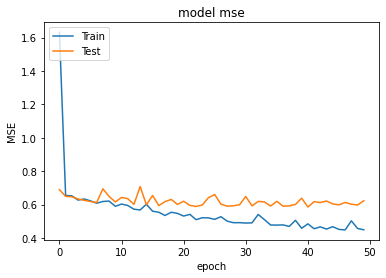

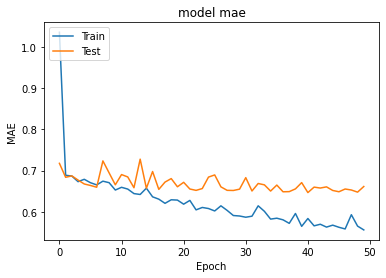

0.6228404641151428
0.6613222360610962


In [116]:
model = Sequential()
model.add(Dense(64, input_dim = dataTrain.shape[1], activation='relu', kernel_initializer='random_uniform', bias_initializer='zeros',kernel_regularizer=l1(0.001)))
model.add(Dense(32, activation='relu', kernel_initializer='random_uniform', bias_initializer='zeros', kernel_regularizer=l1(0.001)))
model.add(Dense(1, activation = 'linear', kernel_initializer='random_uniform', bias_initializer='zeros', kernel_regularizer=l1(0.001)))
opt = optimizers.Adam(lr=0.005)
model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mse', 'mae'])
history = model.fit(dataTrain, labels, validation_data=(dataTest, testLabels), epochs=50, verbose=1, batch_size=32, shuffle=True)

_, mse, mae = model.evaluate(dataTest, testLabels)

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

print(mse)
print(mae)

In [10]:
preds = model.predict(dataTest)

## Tokenization for Sequences

In [38]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True,split=' ')
tokenizer.fit_on_texts(data)
token_list_train = tokenizer.texts_to_sequences(data)
token_list_test = tokenizer.texts_to_sequences(testData)
num_words = len(tokenizer.word_index)+1

In [39]:
length = []
for x in data:
    length.append(len(x.split()))
max_length = max(length)

In [40]:
x_train_seq = pad_sequences(token_list_train, maxlen=max_length)
x_test_seq = pad_sequences(token_list_test, maxlen=max_length)

In [41]:
x_test_seq.shape
x_test_seq=np.asarray(x_test_seq).astype(np.float32)
x_train_seq=np.asarray(x_train_seq).astype(np.float32)
y_test=np.asarray(testLabels).astype(np.float32)
y_train=np.asarray(labels).astype(np.float32)

In [117]:
embedding_matrix = np.zeros((num_words, max_length))
for word, i in tokenizer.word_index.items():
    if word in word2vec_vectors:
        embedding_vector = word2vec[word]
        embedding_matrix[i] = embedding_vector

In [101]:
embedding_matrix = np.zeros((num_words, max_length))
for word, i in tokenizer.word_index.items():
    if word in glove_vectors:
        embedding_vector = glove[word]
        embedding_matrix[i] = embedding_vector

In [48]:
x_train_seq.shape

(1000, 300)

## Sequence MLP Embedding

Epoch 1/50
32/32 [==============================] - 3s 89ms/step - loss: 14.9162 - mse: 2.0616 - mae: 0.9780 - val_loss: 9.2577 - val_mse: 0.7872 - val_mae: 0.7475
Epoch 2/50
32/32 [==============================] - 3s 90ms/step - loss: 7.0946 - mse: 0.5355 - mae: 0.5680 - val_loss: 5.7239 - val_mse: 0.7917 - val_mae: 0.7619
Epoch 3/50
32/32 [==============================] - 3s 85ms/step - loss: 4.3991 - mse: 0.3117 - mae: 0.4514 - val_loss: 4.0736 - val_mse: 0.7677 - val_mae: 0.7359
Epoch 4/50
32/32 [==============================] - 3s 85ms/step - loss: 3.1748 - mse: 0.2469 - mae: 0.3955 - val_loss: 3.4979 - val_mse: 0.8257 - val_mae: 0.7720
Epoch 5/50
32/32 [==============================] - 3s 85ms/step - loss: 2.7943 - mse: 0.2467 - mae: 0.3907 - val_loss: 3.1840 - val_mse: 0.8141 - val_mae: 0.7631
Epoch 6/50
32/32 [==============================] - 3s 85ms/step - loss: 2.4133 - mse: 0.2292 - mae: 0.3701 - val_loss: 2.9018 - val_mse: 0.8229 - val_mae: 0.7632
Epoch 7/50
32/32 [===

16/16 [==============================] - 1s 61ms/step - loss: 1.9482 - mse: 0.8174 - mae: 0.7538


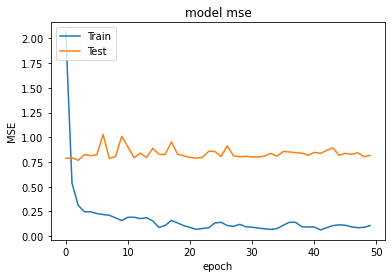

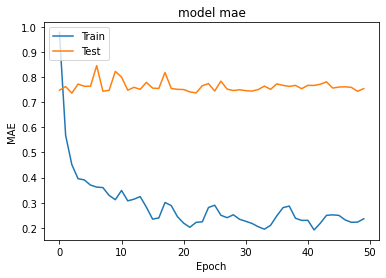

0.8174139857292175
0.7537603974342346


In [105]:
model_1 = Sequential()
model_1.add(Embedding(num_words, x_train_seq.shape[1], weights=[embedding_matrix], input_length=max_length, trainable=False))
model_1.add(Flatten())
init_he_u = initializers.he_uniform(seed=None)
model_1.add(Dense(64, activation='relu',kernel_initializer=init_he_u, kernel_regularizer=l1(0.001)))
model_1.add(Dropout(0.5))
model_1.add(Dense(32, activation='relu',kernel_initializer=init_he_u, kernel_regularizer=l1(0.001)))
model_1.add(Dropout(0.5))
model_1.add(Dense(1, activation='linear', kernel_initializer=init_he_u, kernel_regularizer=l1(0.001)))
model_1.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae'])
history = model_1.fit(x_train_seq, labels, validation_data=(x_test_seq, testLabels), epochs=50, batch_size=32, verbose=1, shuffle=True)

_, mse, mae = model_1.evaluate(x_test_seq, testLabels)

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

print(mse)
print(mae)

## CNN

In [93]:
cnn_1 = Sequential()
cnn_1.add(Embedding(num_words, x_train_seq.shape[1], weights=[embedding_matrix], input_length=max_length, trainable=False))
init_he_u = initializers.he_uniform(seed=None)
cnn_1.add(Conv1D(128, 5, activation='relu', kernel_initializer=init_he_u, kernel_regularizer=l1(0.001)))
cnn_1.add(GlobalMaxPooling1D())
cnn_1.add(Dropout(0.5))
cnn_1.add(Dense(32, activation='relu', kernel_initializer=init_he_u, kernel_regularizer=l1(0.001)))
cnn_1.add(Dropout(0.5))
cnn_1.add(Dense(10, activation='relu', kernel_initializer=init_he_u, kernel_regularizer=l1(0.001)))
cnn_1.add(Flatten())
cnn_1.add(Dense(1, activation='linear', kernel_initializer=init_he_u, kernel_regularizer=l1(0.001)))
cnn_1.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae'])
history = cnn_1.fit(x_train_seq, labels, validation_data=(x_test_seq, testLabels), epochs=50, batch_size=32, verbose=2, shuffle=True)

_, mse, mae = cnn_1.evaluate(x_test_seq, testLabels)

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

print(mse)
print(mae)

Epoch 1/50
32/32 - 27s - loss: 31.3256 - mse: 3.6856 - mae: 1.4978 - val_loss: 22.8283 - val_mse: 2.2622 - val_mae: 1.2555
Epoch 2/50


KeyboardInterrupt: 

## RNN

Epoch 1/50
32/32 - 17s - loss: 4.2660 - mse: 1.8456 - mae: 1.1011 - val_loss: 3.1595 - val_mse: 0.7916 - val_mae: 0.7582
Epoch 2/50
32/32 - 19s - loss: 3.3953 - mse: 1.0767 - mae: 0.8489 - val_loss: 2.9794 - val_mse: 0.7167 - val_mae: 0.7221
Epoch 3/50
32/32 - 21s - loss: 3.0998 - mse: 0.8886 - mae: 0.7828 - val_loss: 2.8780 - val_mse: 0.7244 - val_mae: 0.7349
Epoch 4/50
32/32 - 21s - loss: 2.9825 - mse: 0.8801 - mae: 0.7819 - val_loss: 2.8434 - val_mse: 0.7981 - val_mae: 0.7740
Epoch 5/50
32/32 - 21s - loss: 2.8078 - mse: 0.8121 - mae: 0.7510 - val_loss: 2.6164 - val_mse: 0.6761 - val_mae: 0.7129
Epoch 6/50
32/32 - 20s - loss: 2.6644 - mse: 0.7719 - mae: 0.7349 - val_loss: 2.4856 - val_mse: 0.6454 - val_mae: 0.6945
Epoch 7/50
32/32 - 19s - loss: 2.4897 - mse: 0.6950 - mae: 0.6988 - val_loss: 2.3898 - val_mse: 0.6439 - val_mae: 0.6947
Epoch 8/50
32/32 - 21s - loss: 2.4015 - mse: 0.6975 - mae: 0.6937 - val_loss: 2.3128 - val_mse: 0.6549 - val_mae: 0.7046
Epoch 9/50
32/32 - 21s - loss: 2

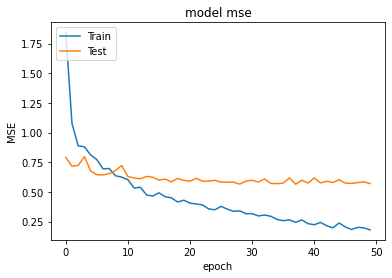

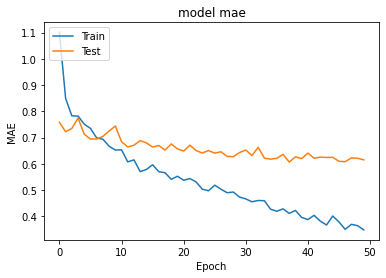

0.5705522298812866
0.6151838302612305


In [118]:
model = Sequential()
model.add(Embedding(input_dim=num_words,
              input_length = max_length,
              output_dim=x_train_seq.shape[1],
              weights=[embedding_matrix],
              trainable=False,
              mask_zero=True))

# Recurrent layer
init_he_u = initializers.he_uniform(seed=None)
model.add(LSTM(64,dropout=0.2, recurrent_dropout=0.2, kernel_initializer=init_he_u))
model.add(Dense(128, activation='relu',kernel_initializer=init_he_u, kernel_regularizer=l1(0.001)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu',kernel_initializer=init_he_u, kernel_regularizer=l1(0.001)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu',kernel_initializer=init_he_u, kernel_regularizer=l1(0.001)))
model.add(Dense(1, activation='linear', kernel_regularizer=l1(0.001)))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])
history = model.fit(x_train_seq, labels, validation_data=(x_test_seq, testLabels), epochs=50, batch_size=32, verbose=2, shuffle=True)

_, mse, mae = model.evaluate(x_test_seq, testLabels)

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

print(mse)
print(mae)